Mounted at /content/drive
Checking paths:
Train CSV exists: True
Val CSV exists: True
Test CSV exists: True

Train shape: (768, 15)
Val shape: (165, 15)
Test shape: (165, 15)

🔎 Training class counts:
DN     : 111
DR     : 329
ERM    : 11
ODC    : 120
ARMD   : 52
BRVO   : 69
AION   : 15
CRVO   : 35
MHL    : 8
RPEC   : 18

Sample images and sizes:


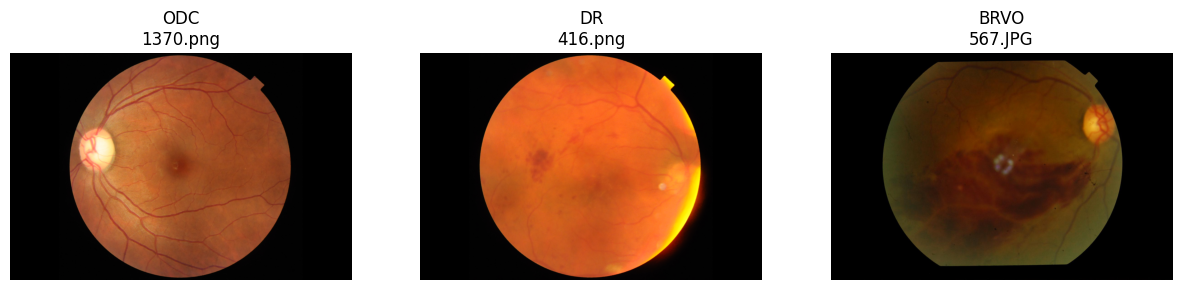

In [ ]:
# =============================
# 📌 COLAB CELL 1 — Mount & Load Splits
# =============================

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------
# Paths for COLAB
# -------------------------

ROOT_COLAB = Path("/content/drive/MyDrive/eye_project")
PROC_COLAB = ROOT_COLAB / "processed" / "splits_strict_10cls_new"

TRAIN_CSV = PROC_COLAB / "train.csv"
VAL_CSV   = PROC_COLAB / "val.csv"
TEST_CSV  = PROC_COLAB / "test.csv"

print("Checking paths:")
print("Train CSV exists:", TRAIN_CSV.exists())
print("Val CSV exists:", VAL_CSV.exists())
print("Test CSV exists:", TEST_CSV.exists())

# -------------------------
# Load DataFrames
# -------------------------
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

# Fix img_path for Colab


print("\nTrain shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)

# -------------------------
# Check class distribution
# -------------------------
label_counts = Counter(train_df['label'])
print("\n🔎 Training class counts:")
for cls, count in label_counts.items():
    print(f"{cls:6s} : {count}")

# -------------------------
# Show sample images
# -------------------------
sample_paths = train_df['img_path'].sample(3, random_state=42).tolist()

print("\nSample images and sizes:")
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for ax, p in zip(axes, sample_paths):
    img = Image.open(p).convert("RGB")
    ax.imshow(img)
    ax.axis("off")
    lab = train_df.loc[train_df['img_path'] == p, 'label'].values[0]
    ax.set_title(lab + "\n" + Path(p).name)

plt.show()

In [ ]:
# =========================================
#  COLAB CELL 2 — OFFLINE CLASS-BALANCING AUGMENTATION
# =========================================

import os
from PIL import Image
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# -----------------------------------------
# Paths
# -----------------------------------------
ROOT = Path("/content/drive/MyDrive/eye_project")
PROC = ROOT / "processed" / "splits_strict_10cls_new"

train_df = pd.read_csv(PROC / "train.csv")

# Augmented output folder
AUG_ROOT = ROOT / "processed" / "augmented_train"
AUG_ROOT.mkdir(parents=True, exist_ok=True)

# -----------------------------------------
# Your augmentation plan EXACTLY as provided
# -----------------------------------------
AUG_PLAN = {
    "AION": 3,
    "ARMD": 2,
    "BRVO": 1,
    "CRVO": 2,
    "DN":   1,
    "DR":   1,
    "ERM":  3,
    "MHL":  3,
    "ODC":  1,
    "RPEC": 3
}

AUG_ANGLES = {
    1: [],
    2: [9],
    3: [9, -9],
}

aug_rows = []

print("\n📌 Starting offline augmentation...")

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    label = row["label"]
    src_path = Path(row["img_path"])

    # make class directory
    class_dir = AUG_ROOT / label
    class_dir.mkdir(parents=True, exist_ok=True)

    # load original image
    img = Image.open(src_path).convert("RGB")

    # ---- save original ----
    orig_name = src_path.stem + "_orig.jpg"
    orig_path = class_dir / orig_name
    img.save(orig_path, quality=95)

    aug_rows.append({
        "label": label,
        "img_path": str(orig_path)
    })

    # ----- augment according to plan -----
    k = AUG_PLAN[label]
    angles = AUG_ANGLES[k]

    for ang in angles:
        aug_img = img.rotate(ang, resample=Image.BILINEAR)
        aug_name = src_path.stem + f"_rot{ang:+}.jpg"
        aug_path = class_dir / aug_name
        aug_img.save(aug_path, quality=95)

        aug_rows.append({
            "label": label,
            "img_path": str(aug_path)
        })

print(" Augmentation complete.")

# -----------------------------------------
# Save new augmented CSV
# -----------------------------------------
aug_df = pd.DataFrame(aug_rows)
aug_csv_path = ROOT / "processed" / "train_augmented.csv"
aug_df.to_csv(aug_csv_path, index=False)

print("\n Augmented CSV saved at:", aug_csv_path)
print("\n New class distribution:")
print(aug_df["label"].value_counts())



📌 Starting offline augmentation...


100%|██████████| 768/768 [12:15<00:00,  1.04it/s]


 Augmentation complete.

 Augmented CSV saved at: /content/drive/MyDrive/eye_project/processed/train_augmented.csv

 New class distribution:
label
DR      329
ODC     120
DN      111
ARMD    104
CRVO     70
BRVO     69
RPEC     54
AION     45
ERM      33
MHL      24
Name: count, dtype: int64


In [ ]:
# ============================================
# 📌 COLAB CELL 3 — DATASET + TRANSFORMS + LOADERS (Inception-v4)
# ============================================

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import pandas as pd
from pathlib import Path

# -----------------------------------------
# Load CSVs
# -----------------------------------------
ROOT = Path("/content/drive/MyDrive/eye_project")
PROC = ROOT / "processed"

train_aug_csv = PROC / "train_augmented.csv"   # NEW augmented CSV
val_csv       = PROC / "splits_strict_10cls_new" / "val.csv"

train_df = pd.read_csv(train_aug_csv)
val_df   = pd.read_csv(val_csv)

print("Loaded augmented train:", train_df.shape)
print("Loaded val:", val_df.shape)

# -----------------------------------------
# CLASS ORDER — must match training and evaluation
# -----------------------------------------
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}

# -----------------------------------------
# TRANSFORMS (Inception-v4 requires 299×299)
# -----------------------------------------
IMG_SIZE = 299

train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# -----------------------------------------
# DATASET CLASS
# -----------------------------------------
class EyeDiseaseDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = row["img_path"]
        label = CLASS_TO_IDX[row["label"]]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return img, label

# -----------------------------------------
# Create datasets & dataloaders
# -----------------------------------------
train_dataset = EyeDiseaseDataset(train_df, train_transform)
val_dataset   = EyeDiseaseDataset(val_df, val_transform)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    num_workers=2, pin_memory=True
)

print("\nDataset + DataLoader ready for Inception-v4")
print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Loaded augmented train: (959, 2)
Loaded val: (165, 15)

Dataset + DataLoader ready for Inception-v4
Train batches: 30
Val batches: 6


In [ ]:
test_csv = PROC / "splits_strict_10cls_new" / "test.csv"
test_df  = pd.read_csv(test_csv)
print("Loaded test:", test_df.shape)

test_dataset = EyeDiseaseDataset(test_df, val_transform)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    num_workers=2, pin_memory=True
)

print("Test batches:", len(test_loader))


Loaded test: (165, 15)
Test batches: 6


In [ ]:
# ============================================
# 📌 COLAB CELL 4 — MODEL + LOSS + OPTIMIZER (Inception-v4)
# ============================================

import torch
import torch.nn as nn
import timm   # Inception-v4 is available only through timm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# -----------------------------------------
# Load pretrained Inception-v4
# -----------------------------------------
model = timm.create_model(
    "inception_v4",
    pretrained=True,
    num_classes=10        # <-- directly sets final layer
)

# Optional extra dropout for regularization
model.dropout = nn.Dropout(0.4)

model = model.to(DEVICE)
print("\n Inception-v4 model loaded and moved to device.")

# -----------------------------------------
# LOSS with label smoothing
# -----------------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# -----------------------------------------
# Optimizer (AdamW)
# -----------------------------------------
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,               # Best hyperparameter for Inception-v4
    weight_decay=1e-4
)

# -----------------------------------------
# OneCycleLR Scheduler
# -----------------------------------------
EPOCHS = 50

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

print("\nOptimizer + Scheduler ready for 50-epoch run.")


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]


 Inception-v4 model loaded and moved to device.

Optimizer + Scheduler ready for 50-epoch run.


In [ ]:
# ============================================
# COLAB CELL 4 — MODEL + LOSS + OPTIMIZER (Inception-v4, 50 epochs)
# ============================================

import torch
import torch.nn as nn
import timm   # Inception-v4 is available via timm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# -----------------------------------------
# Load pretrained Inception-v4
# -----------------------------------------
model = timm.create_model(
    "inception_v4",
    pretrained=True,
    num_classes=10      # final FC replaced automatically
)

# Optional dropout for regularization
model.dropout = nn.Dropout(0.4)

model = model.to(DEVICE)
print("\n  Inception-v4 loaded and moved to device.")

# -----------------------------------------
# LOSS with label smoothing
# -----------------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# -----------------------------------------
# Optimizer (AdamW)
# -----------------------------------------
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,            # best for Inception-v4
    weight_decay=1e-4
)

# -----------------------------------------
# OneCycleLR Scheduler
# -----------------------------------------
EPOCHS = 50    #  (no early stopping)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

print("Optimizer + Scheduler ready — Training scheduled for 50 epochs.")

Device: cuda

  Inception-v4 loaded and moved to device.
Optimizer + Scheduler ready — Training scheduled for 50 epochs.


In [ ]:
# ============================================
#  COLAB CELL 5 — TRAINING + VALIDATION LOOP (Inception-v4, 50 epochs)
# ============================================

import torch
import torch.nn.functional as F
from tqdm import tqdm

# AMP for fast + memory-safe training
scaler = torch.cuda.amp.GradScaler()

def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        # mixed precision forward + loss
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def validate_one_epoch(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


# -----------------------------------------
# 50-epoch Training Loop
# -----------------------------------------
EPOCHS = 50

best_val_acc = 0
history = []
SAVE_PATH = "/content/best_inceptionv4.pth"

print("\n Starting training (Inception-v4 — 50 epochs) \n")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scheduler)
    val_loss, val_acc     = validate_one_epoch(model, val_loader)

    history.append((train_loss, train_acc, val_loss, val_acc))

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), SAVE_PATH)
        print("🔽 BEST MODEL UPDATED")

print("\n Training finished!")
print(f" Best Validation Accuracy: {best_val_acc:.4f}")
print(f" Model saved at: {SAVE_PATH}")


/tmp/ipython-input-399540229.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



 Starting training (Inception-v4 — 50 epochs) 



Training:   0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipython-input-399540229.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating:   0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipython-input-399540229.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/50 | Train Loss: 1.2492 | Train Acc: 0.7112 | Val Loss: 1.2877 | Val Acc: 0.7212
🔽 BEST MODEL UPDATED


Epoch 2/50 | Train Loss: 1.1944 | Train Acc: 0.7237 | Val Loss: 1.2264 | Val Acc: 0.7515
🔽 BEST MODEL UPDATED


Epoch 3/50 | Train Loss: 1.1278 | Train Acc: 0.7508 | Val Loss: 1.1709 | Val Acc: 0.7636
🔽 BEST MODEL UPDATED


Epoch 4/50 | Train Loss: 1.0174 | Train Acc: 0.8008 | Val Loss: 1.1729 | Val Acc: 0.7152


Epoch 5/50 | Train Loss: 0.8828 | Train Acc: 0.8790 | Val Loss: 1.1742 | Val Acc: 0.6970


Epoch 6/50 | Train Loss: 0.8041 | Train Acc: 0.8884 | Val Loss: 1.0581 | Val Acc: 0.7576


Epoch 7/50 | Train Loss: 0.7165 | Train Acc: 0.9291 | Val Loss: 1.2159 | Val Acc: 0.6909


Epoch 8/50 | Train Loss: 0.6800 | Train Acc: 0.9260 | Val Loss: 1.1315 | Val Acc: 0.7212


Epoch 9/50 | Train Loss: 0.6640 | Train Acc: 0.9416 | Val Loss: 1.1107 | Val Acc: 0.7394


Epoch 10/50 | Train Loss: 0.6442 | Train Acc: 0.9458 | Val Loss: 1.2850 | Val Acc: 0.7152


Epoch 11/50 | Train Loss: 0.6335 | Train Acc: 0.9499 | Val Loss: 1.2572 | Val Acc: 0.6909


Epoch 12/50 | Train Loss: 0.6008 | Train Acc: 0.9656 | Val Loss: 1.1497 | Val Acc: 0.7394


Epoch 13/50 | Train Loss: 0.6099 | Train Acc: 0.9614 | Val Loss: 1.1914 | Val Acc: 0.7152


Epoch 14/50 | Train Loss: 0.6075 | Train Acc: 0.9645 | Val Loss: 1.1678 | Val Acc: 0.7636


Epoch 15/50 | Train Loss: 0.5890 | Train Acc: 0.9739 | Val Loss: 1.1834 | Val Acc: 0.7697
🔽 BEST MODEL UPDATED


Epoch 16/50 | Train Loss: 0.5696 | Train Acc: 0.9771 | Val Loss: 1.1556 | Val Acc: 0.7576


Epoch 17/50 | Train Loss: 0.5621 | Train Acc: 0.9812 | Val Loss: 1.1140 | Val Acc: 0.7515


Epoch 18/50 | Train Loss: 0.5560 | Train Acc: 0.9823 | Val Loss: 1.2099 | Val Acc: 0.7333


Epoch 19/50 | Train Loss: 0.5735 | Train Acc: 0.9739 | Val Loss: 1.1183 | Val Acc: 0.7636


Epoch 20/50 | Train Loss: 0.5467 | Train Acc: 0.9854 | Val Loss: 1.1224 | Val Acc: 0.7818
🔽 BEST MODEL UPDATED


Epoch 21/50 | Train Loss: 0.5346 | Train Acc: 0.9896 | Val Loss: 1.1493 | Val Acc: 0.7758


Epoch 22/50 | Train Loss: 0.5425 | Train Acc: 0.9864 | Val Loss: 1.2292 | Val Acc: 0.7515


Epoch 23/50 | Train Loss: 0.5406 | Train Acc: 0.9854 | Val Loss: 1.2328 | Val Acc: 0.7273


Epoch 24/50 | Train Loss: 0.5379 | Train Acc: 0.9875 | Val Loss: 1.2020 | Val Acc: 0.7212


Epoch 25/50 | Train Loss: 0.5309 | Train Acc: 0.9927 | Val Loss: 1.2372 | Val Acc: 0.7273


Epoch 26/50 | Train Loss: 0.5271 | Train Acc: 0.9958 | Val Loss: 1.1610 | Val Acc: 0.7455


Epoch 27/50 | Train Loss: 0.5238 | Train Acc: 0.9948 | Val Loss: 1.1725 | Val Acc: 0.7455


Epoch 28/50 | Train Loss: 0.5144 | Train Acc: 0.9979 | Val Loss: 1.1803 | Val Acc: 0.7636


Epoch 29/50 | Train Loss: 0.5154 | Train Acc: 0.9979 | Val Loss: 1.2196 | Val Acc: 0.7636


Epoch 30/50 | Train Loss: 0.5163 | Train Acc: 0.9969 | Val Loss: 1.1582 | Val Acc: 0.7576


Epoch 31/50 | Train Loss: 0.5154 | Train Acc: 0.9969 | Val Loss: 1.1725 | Val Acc: 0.7758


Epoch 32/50 | Train Loss: 0.5079 | Train Acc: 1.0000 | Val Loss: 1.1687 | Val Acc: 0.7515


Epoch 33/50 | Train Loss: 0.5137 | Train Acc: 0.9958 | Val Loss: 1.2018 | Val Acc: 0.7636


Epoch 34/50 | Train Loss: 0.5092 | Train Acc: 1.0000 | Val Loss: 1.2661 | Val Acc: 0.7273


Epoch 35/50 | Train Loss: 0.5080 | Train Acc: 1.0000 | Val Loss: 1.2251 | Val Acc: 0.7515


Epoch 36/50 | Train Loss: 0.5066 | Train Acc: 1.0000 | Val Loss: 1.1983 | Val Acc: 0.7576


Epoch 37/50 | Train Loss: 0.5088 | Train Acc: 0.9969 | Val Loss: 1.1899 | Val Acc: 0.7576


Epoch 38/50 | Train Loss: 0.5082 | Train Acc: 0.9990 | Val Loss: 1.1816 | Val Acc: 0.7455


Epoch 39/50 | Train Loss: 0.5072 | Train Acc: 0.9990 | Val Loss: 1.1925 | Val Acc: 0.7515


Epoch 40/50 | Train Loss: 0.5063 | Train Acc: 1.0000 | Val Loss: 1.1995 | Val Acc: 0.7697


Epoch 41/50 | Train Loss: 0.5076 | Train Acc: 0.9990 | Val Loss: 1.2023 | Val Acc: 0.7576


Epoch 42/50 | Train Loss: 0.5069 | Train Acc: 1.0000 | Val Loss: 1.1908 | Val Acc: 0.7576


Epoch 43/50 | Train Loss: 0.5077 | Train Acc: 0.9990 | Val Loss: 1.2111 | Val Acc: 0.7515


Epoch 44/50 | Train Loss: 0.5097 | Train Acc: 0.9990 | Val Loss: 1.1866 | Val Acc: 0.7576


Epoch 45/50 | Train Loss: 0.5083 | Train Acc: 0.9979 | Val Loss: 1.1764 | Val Acc: 0.7636


Epoch 46/50 | Train Loss: 0.5064 | Train Acc: 1.0000 | Val Loss: 1.1767 | Val Acc: 0.7636


Epoch 47/50 | Train Loss: 0.5061 | Train Acc: 1.0000 | Val Loss: 1.1721 | Val Acc: 0.7697


Epoch 48/50 | Train Loss: 0.5091 | Train Acc: 0.9979 | Val Loss: 1.1749 | Val Acc: 0.7515


Epoch 49/50 | Train Loss: 0.5060 | Train Acc: 1.0000 | Val Loss: 1.1901 | Val Acc: 0.7636


ValueError: Tried to step 1501 times. The specified number of total steps is 1500

In [ ]:
torch.save(model.state_dict(), "/content/inceptionv4_latest_50epochs.pth")
print("Latest model saved!")


Latest model saved!


Model loaded successfully for evaluation!


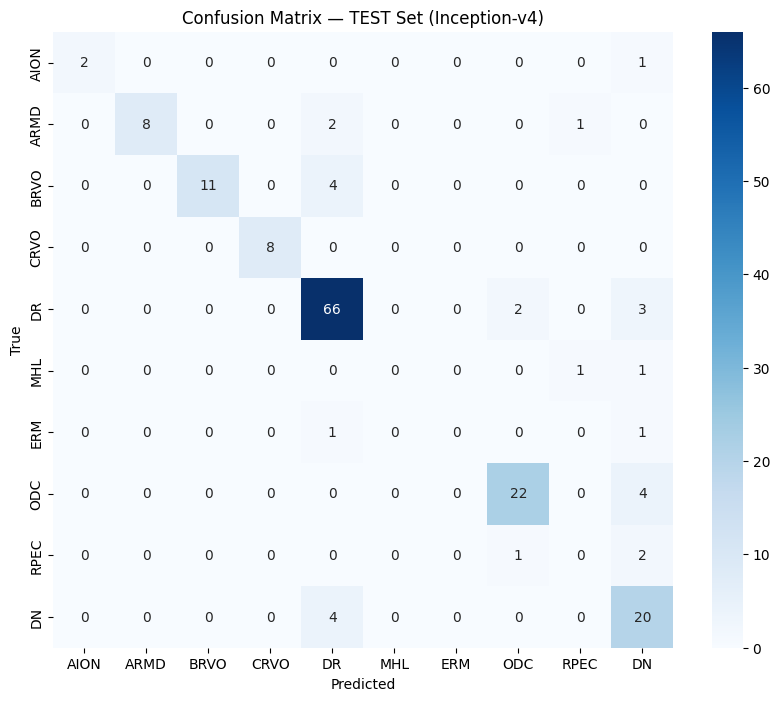


 CLASSIFICATION REPORT — TEST Set (Inception-v4)

              precision    recall  f1-score   support

        AION     1.0000    0.6667    0.8000         3
        ARMD     1.0000    0.7273    0.8421        11
        BRVO     1.0000    0.7333    0.8462        15
        CRVO     1.0000    1.0000    1.0000         8
          DR     0.8571    0.9296    0.8919        71
         MHL     0.0000    0.0000    0.0000         2
         ERM     0.0000    0.0000    0.0000         2
         ODC     0.8800    0.8462    0.8627        26
        RPEC     0.0000    0.0000    0.0000         3
          DN     0.6250    0.8333    0.7143        24

    accuracy                         0.8303       165
   macro avg     0.6362    0.5736    0.5957       165
weighted avg     0.8226    0.8303    0.8197       165



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# =====================================================
#  COLAB CELL — FINAL EVALUATION (TEST SET) Inception-v4
# =====================================================

import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#  Path to your latest saved model (after 50 epochs)
BEST_MODEL_PATH = "/content/inceptionv4_latest_50epochs.pth"   # ⬅ update path if needed

#  Load model weights safely (CPU or GPU)
state_dict = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()
print("Model loaded successfully for evaluation!")

# -----------------------------------------
# 🔍 Evaluate on TEST dataset
# -----------------------------------------
true_labels = []
pred_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())


# -----------------------------------------
# 📌 Confusion Matrix
# -----------------------------------------
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix — TEST Set (Inception-v4)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# -----------------------------------------
# Classification Report
# -----------------------------------------
from sklearn.metrics import classification_report
print("\n CLASSIFICATION REPORT — TEST Set (Inception-v4)\n")
print(classification_report(true_labels, pred_labels, target_names=CLASSES, digits=4))


In [ ]:
# ============================================
#  CELL — RECONSTRUCT HISTORY FROM TRAINING LOG (50 epochs — Inception-v4)
# ============================================

history = [
    (1.2492, 0.7112, 1.2877, 0.7212),
    (1.1944, 0.7237, 1.2264, 0.7515),
    (1.1278, 0.7508, 1.1709, 0.7636),
    (1.0174, 0.8008, 1.1729, 0.7152),
    (0.8828, 0.8790, 1.1742, 0.6970),
    (0.8041, 0.8884, 1.0581, 0.7576),
    (0.7165, 0.9291, 1.2159, 0.6909),
    (0.6800, 0.9260, 1.1315, 0.7212),
    (0.6640, 0.9416, 1.1107, 0.7394),
    (0.6442, 0.9458, 1.2850, 0.7152),
    (0.6335, 0.9499, 1.2572, 0.6909),
    (0.6008, 0.9656, 1.1497, 0.7394),
    (0.6099, 0.9614, 1.1914, 0.7152),
    (0.6075, 0.9645, 1.1678, 0.7636),
    (0.5890, 0.9739, 1.1834, 0.7697),
    (0.5696, 0.9771, 1.1556, 0.7576),
    (0.5621, 0.9812, 1.1140, 0.7515),
    (0.5560, 0.9823, 1.2099, 0.7333),
    (0.5735, 0.9739, 1.1183, 0.7636),
    (0.5467, 0.9854, 1.1224, 0.7818),
    (0.5346, 0.9896, 1.1493, 0.7758),
    (0.5425, 0.9864, 1.2292, 0.7515),
    (0.5406, 0.9854, 1.2328, 0.7273),
    (0.5379, 0.9875, 1.2020, 0.7212),
    (0.5309, 0.9927, 1.2372, 0.7273),
    (0.5271, 0.9958, 1.1610, 0.7455),
    (0.5238, 0.9948, 1.1725, 0.7455),
    (0.5144, 0.9979, 1.1803, 0.7636),
    (0.5154, 0.9979, 1.2196, 0.7636),
    (0.5163, 0.9969, 1.1582, 0.7576),
    (0.5154, 0.9969, 1.1725, 0.7758),
    (0.5079, 1.0000, 1.1687, 0.7515),
    (0.5137, 0.9958, 1.2018, 0.7636),
    (0.5092, 1.0000, 1.2661, 0.7273),
    (0.5080, 1.0000, 1.2251, 0.7515),
    (0.5066, 1.0000, 1.1983, 0.7576),
    (0.5088, 0.9969, 1.1899, 0.7576),
    (0.5082, 0.9990, 1.1816, 0.7455),
    (0.5072, 0.9990, 1.1925, 0.7515),
    (0.5063, 1.0000, 1.1995, 0.7697),
    (0.5076, 0.9990, 1.2023, 0.7576),
    (0.5069, 1.0000, 1.1908, 0.7576),
    (0.5077, 0.9990, 1.2111, 0.7515),
    (0.5097, 0.9990, 1.1866, 0.7576),
    (0.5083, 0.9979, 1.1764, 0.7636),
    (0.5064, 1.0000, 1.1767, 0.7636),
    (0.5061, 1.0000, 1.1721, 0.7697),
    (0.5091, 0.9979, 1.1749, 0.7515),
    (0.5060, 1.0000, 1.1901, 0.7636)
]

print(" history recreated with", len(history), "epochs.")


 history recreated with 49 epochs.


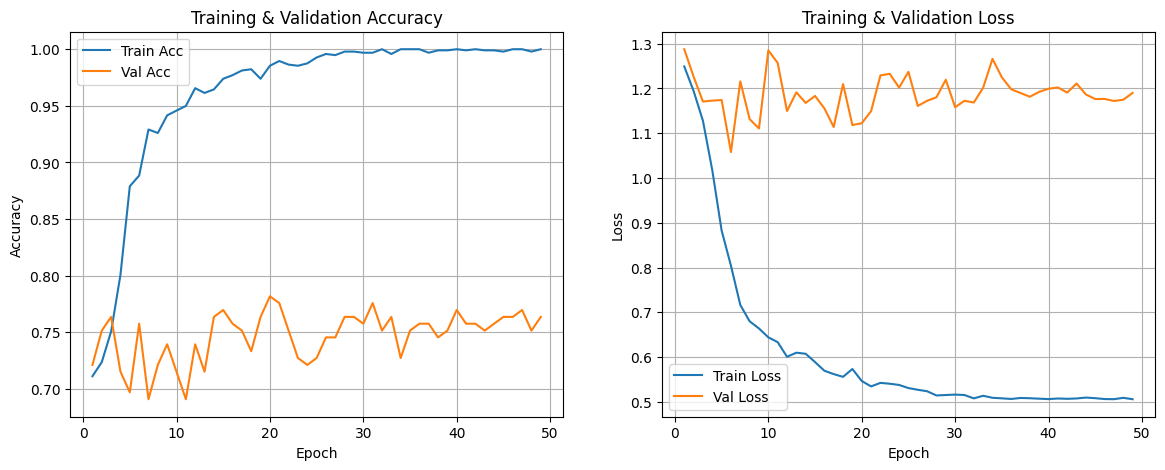

In [ ]:
import matplotlib.pyplot as plt

train_loss = [h[0] for h in history]
train_acc  = [h[1] for h in history]
val_loss   = [h[2] for h in history]
val_acc    = [h[3] for h in history]

epochs = range(1, len(history)+1)

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.show()


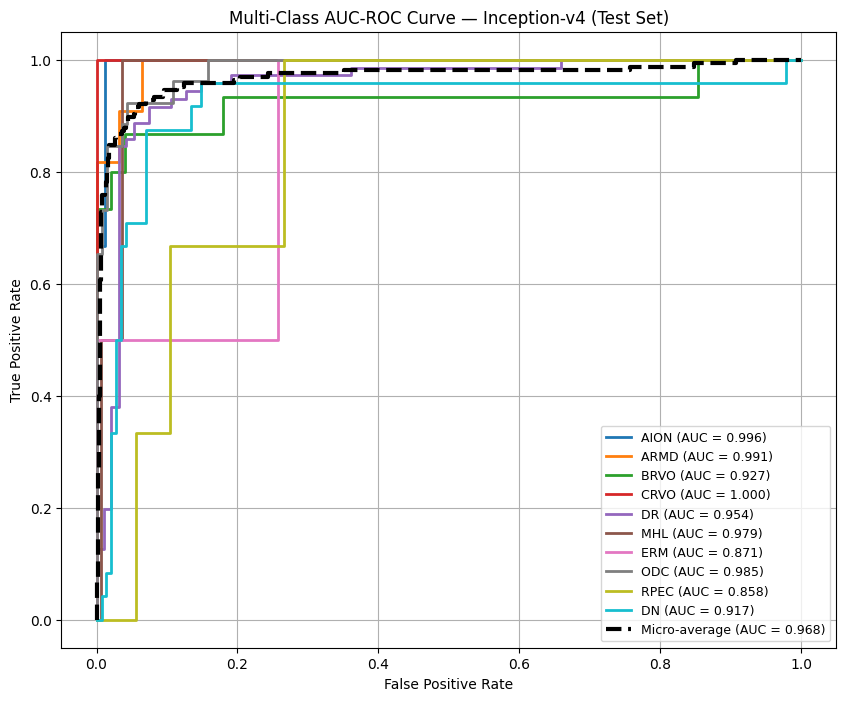


 AUC SCORES PER CLASS:
AION : AUC = 0.9959
ARMD : AUC = 0.9911
BRVO : AUC = 0.9271
CRVO : AUC = 1.0000
DR   : AUC = 0.9539
MHL  : AUC = 0.9785
ERM  : AUC = 0.8712
ODC  : AUC = 0.9845
RPEC : AUC = 0.8580
DN   : AUC = 0.9170

 Micro-Average AUC: 0.9677
 Macro-Average AUC: 0.9477


In [ ]:
# ============================================
# 📌 MULTI-CLASS AUC-ROC (TEST) — WITH MACRO AVG
# ============================================

import torch
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

all_probs = []
all_labels = []

# ---- Collect probabilities ----
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        all_probs.append(probs)
        all_labels.append(labels.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# ---- One-hot encoding ----
y_onehot = label_binarize(all_labels, classes=list(range(len(CLASSES))))

# ---- ROC/AUC ----
fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(10, 8))

for i in range(len(CLASSES)):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"{CLASSES[i]} (AUC = {roc_auc[i]:.3f})")

# ---- Micro-Average ----
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(fpr["micro"], tpr["micro"],
         linestyle='--', color='black', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")

# ---- Macro-Average ----
roc_auc["macro"] = np.mean([roc_auc[i] for i in range(len(CLASSES))])

plt.title("Multi-Class AUC-ROC Curve — Inception-v4 (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.show()

# ---- Print scores ----
print("\n AUC SCORES PER CLASS:")
for i in range(len(CLASSES)):
    print(f"{CLASSES[i]:5s}: AUC = {roc_auc[i]:.4f}")

print(f"\n Micro-Average AUC: {roc_auc['micro']:.4f}")
print(f" Macro-Average AUC: {roc_auc['macro']:.4f}")
